In [1]:
import tensorflow as tf
from os.path import isfile, isdir
import numpy as np
import pickle, time
from tqdm import tqdm
import tarfile
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with tarfile.open('cifar-10-python.tar.gz') as tar:
    tar.extractall()
    tar.close()

In [ ]:
def prepare_cfar10_batches(folder, batch_id,mode='train'):
    """
    Load and pre-process dataset
    """
    infile=folder + '/data_batch_' + str(batch_id) if mode=='train' else folder+'/test_batch'
    outfile='train_batch_'+str(batch_id)+'.p' if mode=='train' else 'test_batch.p'
    
    with open(infile, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    
    if np.max(features)<1.01:
        raise ValueError('It seems that the data is already normalized to 1')
        
    features=(features-128)/255.0 #pre-process images
    labels=np.eye(10)[labels] #convert labels to one hot vectors
    pickle.dump((features, labels), open(outfile, 'wb')) #save

In [ ]:
for batch_num in range(1,6):
    prepare_cfar10_batches('./cifar-10-batches-py',batch_num)
prepare_cfar10_batches('./cifar-10-batches-py',1,mode='test')

In [2]:
def get_mini_batches(batch_num,mini_batch_size=64):
    filename='train_batch_'+str(batch_num)+'.p'
    with open(filename,mode='rb') as f:
        features,labels=pickle.load(f)
    for begin in range(0,len(features),mini_batch_size):
        end=min(begin+mini_batch_size,len(features))
        yield features[begin:end],labels[begin:end]

def get_test_set():
    with open('test_batch.p',mode='rb') as f:
        features,labels=pickle.load(f)
    return features,labels

test_x,test_y=get_test_set()

In [3]:
im_size=(None,32,32,3) #size of images
n_classes=10 #number of categories

In [4]:
def myswish(x):
    return x*tf.nn.sigmoid(x)

def myswish_beta(x):
    beta=tf.Variable(initial_value=1.0,trainable=True,name='swish_beta')
    return x*tf.nn.sigmoid(beta*x) #trainable parameter beta

functions={'identity':tf.identity,'sigmoid':tf.nn.sigmoid,'relu':tf.nn.relu,'swish_1':myswish,'swish_beta':myswish_beta}

In [5]:
def get_placeholders(im_size,n_classes):
    inputs_=tf.placeholder(tf.float32,[*im_size])
    targets=tf.placeholder(tf.float32,[None,n_classes])
    lr=tf.placeholder(tf.float32)
    drop=tf.placeholder(tf.float32)
    return inputs_,targets,lr,drop

In [6]:
def make_convnet(inputs_,targets,lr,dropout,filter_size,n_layers,activation_name):
    activation=functions[activation_name]
    assert n_layers%3==0, 'Please make sure that number of layers is a multiple of 3'
    
    layer=tf.layers.conv2d(inputs_,64,filter_size,strides=(2,2),padding='same') #output is 16x16x64
    layer=activation(layer)
    
    def computational_bottleneck(inlayer,num): #from ResNet paper
        in_filters=inlayer.get_shape().as_list()[-1]
        assert in_filters%4==0,'Please make sure that number of filters is a multiple of 4'
        with tf.name_scope('comp_block_'+str(num)): #makes it easier to visualize in tensorboard
            layer1=tf.layers.conv2d(inlayer,in_filters//4,kernel_size=(1,1),padding='same')
            layer1=activation(layer1)
            layer2=tf.layers.conv2d(layer1,in_filters//4,kernel_size=(3,3),padding='same')
            layer2=activation(layer2)
            layer2=tf.nn.dropout(layer2,keep_prob=dropout) #regularize this layer

            outlayer=tf.layers.conv2d(layer2,in_filters,kernel_size=(1,1),padding='same')
            #no activation here
        return outlayer
    
    n_blocks=(n_layers-3)//3
    
    for block in range(n_blocks):
        layer=activation(layer+activation(computational_bottleneck(layer,block))) #apply activation
        
    conv6=tf.layers.conv2d(layer,128,filter_size,strides=(2,2),padding='same')
    conv6=activation(conv6)
    conv6=tf.nn.dropout(conv6,keep_prob=dropout)
    conv7=tf.layers.conv2d(conv6,256,filter_size,strides=(2,2),padding='same')
    conv7=tf.reduce_mean(tf.reduce_mean(conv7,axis=1),axis=1)
    
    output_logits=tf.layers.dense(conv7,n_classes)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logits,labels=targets))
    accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(targets,axis=1),tf.argmax(output_logits,axis=1)),tf.float32))
    opt=tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    return cost,accuracy,opt

In [20]:
filter_size=[3,3]
n_layers=12 #make sure this is a multiple of 3
epochs=10
learning_rate=5e-4
mini_batch_size=128
pkeep=0.75

In [21]:
for func in ['relu','swish_1','swish_beta']:
    tf.reset_default_graph()
    graph=tf.get_default_graph()
    inputs_,targets,lr,dropout= get_placeholders(im_size,n_classes)
    loss,acc,opt=make_convnet(inputs_,targets,lr,dropout,filter_size,n_layers,func)
    train_acc=[]
    valid_acc=[]
    batch_times=[]
    inference_times=[]
    #isbeta= len([n.name for n in tf.get_default_graph().as_graph_def().node if 'swish_beta' in n.name])>0
    #sorry, this looks slightly convoluted, we just want to find whether a tensor by name 'swish_beta' exists

    with tf.Session(graph=graph) as sess:
        saver=tf.train.Saver()
        tf.set_random_seed(0)
        sess.run(tf.global_variables_initializer())
        if func=='swish_beta':
            beta_values=[]
            beta_=graph.get_tensor_by_name('swish_beta:0')

        for e in range(epochs):
            count=0
            for batch_i in range(1,6):
                for batch_x,batch_y in get_mini_batches(batch_i,mini_batch_size):
                    feed={inputs_:batch_x,targets:batch_y,lr:learning_rate,dropout:pkeep}
                    starting=time.time()
                    tloss,tacc,_=sess.run([loss,acc,opt],feed_dict=feed)
                    ending=time.time()
                    batch_times.append(ending-starting)
                    train_acc.append(tacc)
                    if func=='swish_beta':
                        beta_values.append(beta_.eval())
                        #print('beta={:.3f}'.format(beta_.eval()))
                    count+=1
                    
                    if count%20==0:
                        feed={inputs_:test_x,targets:test_y,dropout:1.0} #use test set for validation (!)
                        valid=sess.run(acc,feed_dict=feed)
                        valid_acc.append(valid)
                        print('Activation: {}, Epoch {}/{},Batch #{}. Training loss={:.3f}, validation accuracy: {:.3f}'\
                              .format(func,e+1,epochs,count,tloss,valid))
        try:
            saver.save(sess,'checkpoints/'+func+'/model')
        except:
            print('Could not save model')
        
        for idx in range(100):
            feed={inputs_:test_x[:100],targets:test_y[:100],dropout:1.0} #use test set for validation (!)
            starting=time.time()
            valid=sess.run(acc,feed_dict=feed)
            ending=time.time()
            inference_times.append(ending-starting)
            
        with open(func+'.p','wb') as f:
            pickle.dump((train_acc,valid_acc,batch_times,inference_times),f)

Activation: relu, Epoch 1/10,Batch #20. Training loss=2.286, validation accuracy: 0.107
Activation: relu, Epoch 1/10,Batch #40. Training loss=2.268, validation accuracy: 0.165
Activation: relu, Epoch 1/10,Batch #60. Training loss=2.169, validation accuracy: 0.171
Activation: relu, Epoch 1/10,Batch #80. Training loss=2.092, validation accuracy: 0.215
Activation: relu, Epoch 1/10,Batch #100. Training loss=2.071, validation accuracy: 0.215
Activation: relu, Epoch 1/10,Batch #120. Training loss=2.061, validation accuracy: 0.230
Activation: relu, Epoch 1/10,Batch #140. Training loss=2.120, validation accuracy: 0.269
Activation: relu, Epoch 1/10,Batch #160. Training loss=1.979, validation accuracy: 0.243
Activation: relu, Epoch 1/10,Batch #180. Training loss=2.008, validation accuracy: 0.281
Activation: relu, Epoch 1/10,Batch #200. Training loss=1.983, validation accuracy: 0.301
Activation: relu, Epoch 1/10,Batch #220. Training loss=1.930, validation accuracy: 0.262
Activation: relu, Epoch 1

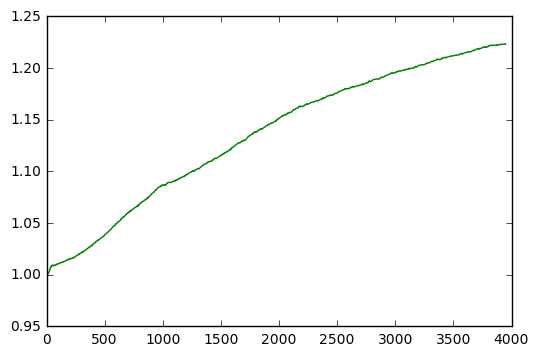

In [22]:
plt.plot(beta_values,'g')
plt.xlabel='Training step #'
plt.ylabel='beta'
plt.show()

In [ ]:
plt.plot(valid_acc,'b')
plt.show()

In [3]:
colors={'identity':'red','sigmoid':'green','relu':'blue','swish_1':'orange','swish_beta':'firebrick'}

In [4]:
from bokeh.plotting import figure, output_file,output_notebook, show

In [6]:
p=figure(title='{} layer network'.format(n_layers))
for func in ['relu','swish_1','swish_beta']:
    with open(func+'.p','rb') as f:
        _,validation,_,_=pickle.load(f)
    p.line(range(0,10*len(validation),10),validation,legend=func,color=colors[func])
    p.xaxis.axis_label='Training step'
    p.yaxis.axis_label='Validation accuracy'
p.legend.click_policy='hide'
p.legend.location='bottom_right'
output_notebook()
output_file('accuracy_{}.html'.format(n_layers),title='Activation functions')
show(p)

Loading BokehJS ...

In [7]:
p=figure(title='{} layer network'.format(n_layers)) #y_range=(0,0.27),
for func in ['relu','swish_1','swish_beta']:
    with open(func+'.p','rb') as f:
        _,_,train_time,_=pickle.load(f)
        train_time=np.array(train_time)
    fill_value=np.mean(train_time[train_time>0.15]) #one of the batches had a very small size, which resulted
    train_time[train_time<0.15]=fill_value #in a graph with large dips for that batch at each epoch. #This is just to filter out those dips
    print('Average train time for {}:{}'.format(func,np.mean(train_time)))
    p.line(range(len(train_time)),train_time,legend=func,color=colors[func])
    p.xaxis.axis_label='Training step'
    p.yaxis.axis_label='Batch time (forward & backward pass)'
p.legend.click_policy='hide'
p.legend.location='top_right'
output_notebook()
output_file('traintime_{}.html'.format(n_layers),title='Activation functions')
show(p)

Average train time for relu:0.3095997853156848
Average train time for swish_1:0.36302074401806567
Average train time for swish_beta:0.393171130449344


Loading BokehJS ...

In [19]:
p=figure(title='{} layer network'.format(n_layers))
for func in ['relu','swish_1','swish_beta']:
    with open(func+'.p','rb') as f:
        _,_,_,inf_time=pickle.load(f)
    p.line(range(len(inf_time)),inf_time,legend=func,color=colors[func])
    p.xaxis.axis_label='Training step'
    p.yaxis.axis_label='Inference time (only forward pass)'
p.legend.click_policy='hide'
p.legend.location='bottom_right'
output_file('inferencetime_{}.html'.format(n_layers),title='Activation functions')
show(p)